# Using CARTOframes to investigate Citibike station demand

What does the Citibike station system look like right now? Citibike publishes an open feed of station statuses. Using CARTOframes, let's create a Citibike station map, draw a five minute walking radius around a Citibike station, and figure out how many people live within five minutes of a Citibike station. This can give us a picture of Citibike stations that might be in high demand during the morning commute. Notebook is viewable here: http://nbviewer.jupyter.org/github/CartoDB/cartoframes/blob/more-examples/examples/Demo%20%28Citibike%20Stations%29.ipynb

In [16]:
import cartoframes
from cartoframes import Credentials
from cartoframes import Layer, BaseMap, styling
import pandas as pd
%matplotlib inline

In [24]:
USERNAME = 'michellemho-carto'  # <-- replace with your username 
APIKEY = 'abcde'       # <-- your CARTO API key
creds = Credentials(username=USERNAME, 
                    key=APIKEY)
creds.save()  # save credentials for later use (not dependent on Python session)
cc = cartoframes.CartoContext(creds)

In [25]:
# Use Pandas to read a JSON of Citibike stations and their statuses
stations_data = pd.read_json('https://gbfs.citibikenyc.com/gbfs/en/station_information.json')
stations = pd.DataFrame(stations_data.data[0])
status_data = pd.read_json('https://gbfs.citibikenyc.com/gbfs/en/station_status.json')
status = pd.DataFrame(status_data.data[0])

In [26]:
# Grab the last updated timestamps
timestamp_stations = stations_data.last_updated[0]
timestamp_status = status_data.last_updated[0]

In [27]:
# Join the station and statuses together by 'station_id'
station_status = pd.merge(stations,status,how='left', on='station_id')

In [28]:
station_status.head(2)

,capacity,eightd_has_key_dispenser,lat,lon,name,region_id,rental_methods,rental_url,short_name,station_id,eightd_has_available_keys,is_installed,is_renting,is_returning,last_reported,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled
0,39,False,40.767272,-73.993929,W 52 St & 11 Ave,71.0,"[KEY, CREDITCARD]",http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,6926.01,72,False,1,1,1,1510083456,6,0,33,0
1,33,False,40.719116,-74.006667,Franklin St & W Broadway,71.0,"[KEY, CREDITCARD]",http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,5430.08,79,False,1,1,1,1510084671,32,0,1,0


In [29]:
# Write station status data to CARTO
cc.write(station_status, 'cb_stations_status_{}'.format(timestamp_stations), lnglat=('lon','lat'), overwrite=True)

Table successfully written to CARTO: https://michellemho-carto.carto.com/dataset/cb_stations_status_1510084705


In [30]:
# Bring the data back as a map.
cc.map(layers=[Layer('cb_stations_status_{}'.format(timestamp_stations))])

In [31]:
# Style by number of bikes available at each station 
cc.map(layers=[Layer('cb_stations_status_{}'.format(timestamp_stations),
       color={'column': 'num_bikes_available'})])

In [32]:
# Change color ramp scheme and set bin method
cc.map(layers=[Layer('cb_stations_status_{}'.format(timestamp_stations),
       color={'column': 'num_bikes_available',
              'scheme': styling.geyser(7, bin_method='quantiles')})])

In [33]:
# Change size and basemap style
cc.map(layers=[Layer('cb_stations_status_{}'.format(timestamp_stations),
                    color={'column': 'num_bikes_available',
                           'scheme': styling.geyser(7, bin_method='quantiles')},
                    size=6),BaseMap(source='dark')])

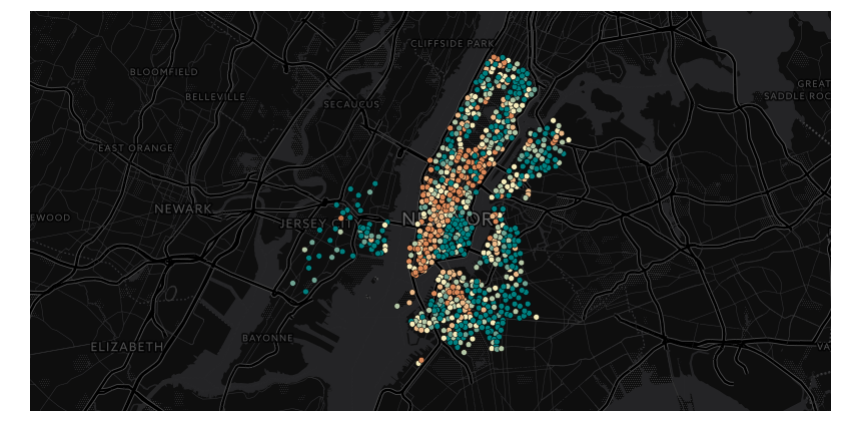

In [34]:
# Static map
cc.map(layers=[Layer('cb_stations_status_{}'.format(timestamp_stations),
                    color={'column': 'num_bikes_available',
                           'scheme': styling.geyser(7, bin_method='quantiles')},
                    size=6),BaseMap(source='dark')],
      interactive=False)

Let's take advantage of external data APIs built into CARTO to do more investigating

In [35]:
# set up SQL query for buffering around stations with walk radius of five minutes, using CARTO dataservices API
buffer_query = '''
        SELECT cartodb_id,
               num_bikes_available,
               lat,
               lon,
               capacity,
               (cdb_isochrone(the_geom, 'walk', ARRAY[300]::integer[])).the_geom as the_geom
        FROM cb_stations_status_{}
        '''.format(timestamp_stations)

In [36]:
# use cartoframes query method to create the new table, now with isochrone geometries
# will take a minute to calculate and will return a new dataframe
cb_stations_buffered = cc.query(buffer_query, table_name='cb_stations_walkbuffer')

In [37]:
# map the buffered stations
cc.map(layers=[Layer('cb_stations_walkbuffer',
                    color={'column': 'num_bikes_available',
                           'scheme': styling.geyser(7, bin_method='quantiles')}),BaseMap(source='dark')],
       interactive=True)

In [39]:
# set up query for data augmentation from the Data Observatory API
total_pop = [{'numer_id': 'us.census.acs.B01003001'}]
# Add column for total_population
walk_buffer_wpop = cc.data_augment('cb_stations_walkbuffer',total_pop)

In [40]:
# map the walk buffers, style by population
cc.map(layers=[Layer('cb_stations_walkbuffer',
                    color={'column': 'total_pop_area_2011_2015',
                           'scheme': styling.geyser(7, bin_method='quantiles')}),BaseMap(source='dark')],
       interactive=True)

It looks like Uptown Citibike stations and East Village/Lower East Side stations serve a larger population compared to the rest. Some questions we can start asking: are the capacity or density of Citibike stations in these areas meet this demand?